In [1]:
import os, sys, numpy as np, torch, matplotlib.pyplot as plt, cv2
sys.path.append(os.path.abspath(".."))

from core.model import TumorNet34Bayes
from core.utils import GradCAMpp
from contextlib import contextmanager

c:\Users\surya\anaconda3\envs\tf-gpu\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
ROOT_DIR = os.path.abspath("..")
DATA_DIR = os.path.join(ROOT_DIR, "data", "processed")
CKPT_DIR = os.path.join(ROOT_DIR, "results", "checkpoints")
VIS_DIR  = os.path.join(ROOT_DIR, "results", "visualizations")
os.makedirs(VIS_DIR, exist_ok=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = TumorNet34Bayes(dropout_p=0.4).to(device)
model.load_state_dict(torch.load(
    os.path.join(CKPT_DIR, "model_weights_best.pth"),  
    map_location=device
))
model.eval()

C:\Users\surya\AppData\Local\Temp\ipykernel_7744\3669163939.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


TumorNet34Bayes(
  (stem_bayes): VBConv2d()
  (stem_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stem_relu): ReLU(inplace=True)
  (stem_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(

In [5]:
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))
X_test_t = torch.tensor(X_test, dtype=torch.float32).permute(0,3,1,2).to(device)

In [6]:
idx = 0
x = X_test_t[idx:idx+1]

gc = GradCAMpp(model, target_layer="layer4")
model.zero_grad(set_to_none=True)

In [7]:
logits, conf, probs = model(x)      
logits.sum().backward()
cam = gc.generate(logits).squeeze(0).detach().cpu().numpy()
gc.remove()

c:\Users\surya\anaconda3\envs\tf-gpu\lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


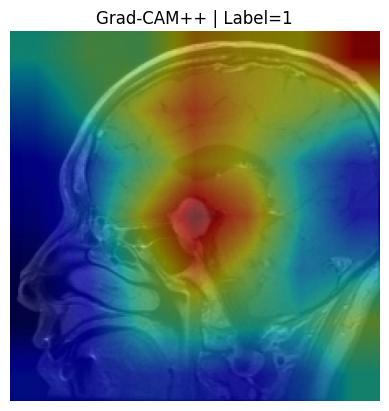

In [8]:
base_img = (X_test[idx] * 255).astype(np.uint8)
cam_up = cv2.resize(cam, (base_img.shape[1], base_img.shape[0]))
plt.imshow(base_img)
plt.imshow(cam_up, cmap="jet", alpha=0.5)
plt.title(f"Grad-CAM++ | Label={int(y_test[idx])}")
plt.axis("off")
plt.savefig(os.path.join(VIS_DIR, "gradcampp_example.png"))
plt.show()

In [9]:
@contextmanager
def enable_dropout(model):
    """Context manager to enable dropout during inference."""
    training_states = {}
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            training_states[m] = m.training
            m.train()
    try:
        yield
    finally:
        for m, state in training_states.items():
            m.train(state)

In [10]:
@torch.no_grad()
def mc_pass(model, x, T=20):
    """MC Dropout forward pass safe for batch size 1."""
    preds = []
    with enable_dropout(model):  
        for _ in range(T):
            logits, probs, conf = model(x) 
            preds.append(torch.sigmoid(logits))
    preds = torch.stack(preds, dim=0)
    return preds.mean(0).squeeze(1), preds.std(0).squeeze(1)

In [11]:
idx = 1
x = X_test_t[idx:idx+1]
mean_p, epistemic = mc_pass(model, x, T=20)

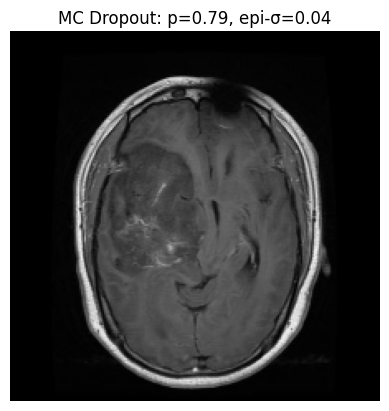

In [12]:
plt.imshow(X_test[idx])
plt.title(f"MC Dropout: p={float(mean_p.item()):.2f}, epi-σ={float(epistemic.item()):.2f}")
plt.axis("off")
plt.savefig(os.path.join(VIS_DIR, "uncertainty_example.png"))
plt.show()